In [2]:
import os
print(os.getcwd())
%run setup_path.py
from src.data_loader import get_log_returns

/Users/mattg/Developer/GBPUSD-X-Volatility-Forecasting/notebooks
✅ Project root set to: /Users/mattg/Developer/GBPUSD-X-Volatility-Forecasting


In [3]:
import matplotlib.pyplot as plt
from arch import arch_model
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

/Users/mattg/Developer/GBPUSD-X-Volatility-Forecasting/src/data_loader.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Ticker      GBPUSD=X
Date                
2015-01-02 -0.007796
2015-01-05 -1.892271
2015-01-06 -0.173944
2015-01-07 -0.788688
2015-01-08 -0.200927
...              ...
2024-12-25  0.012544
2024-12-26  0.061459
2024-12-27 -0.111514
2024-12-30  0.391457
2024-12-31 -0.236176

[2605 rows x 1 columns]


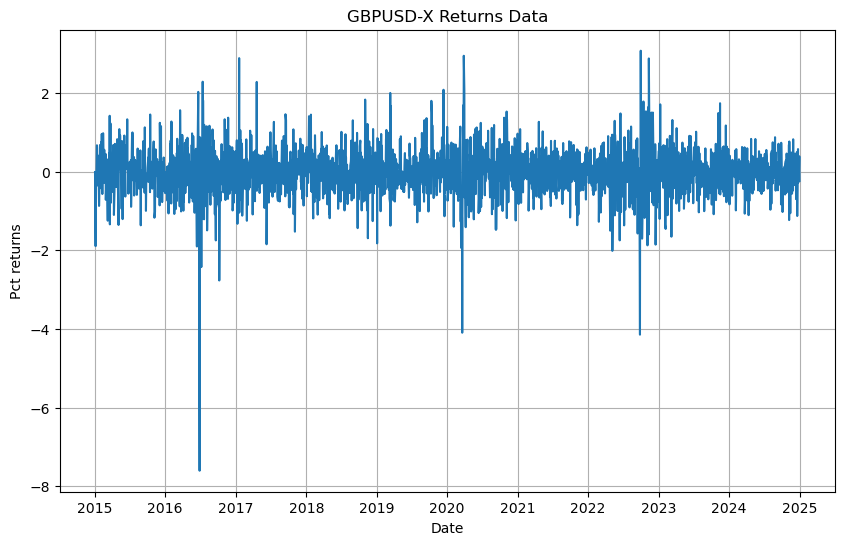

In [4]:
pct_returns = 100*get_log_returns() # compute pct returns
pct_returns.dropna()

print(pct_returns)
# Plot the historical returns data
plt.figure(figsize=(10, 6))
plt.plot(pct_returns.index, pct_returns)
plt.xlabel("Date")
plt.ylabel("Pct returns")
plt.title("GBPUSD-X Returns Data")
plt.grid(True)

plt.show()

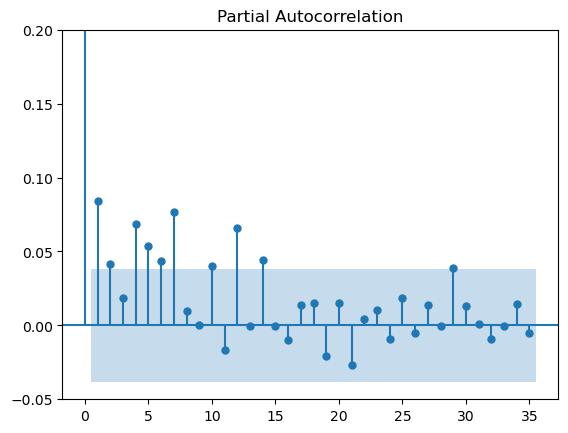

In [5]:
# plot PACF 
plot_pacf(pct_returns**2)
plt.ylim(-0.05, 0.2)
plt.show()

In [15]:
model = arch_model(pct_returns, p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 12057.80185634387
Iteration:      2,   Func. Count:     18,   Neg. LLF: 895630.6334225081
Iteration:      3,   Func. Count:     29,   Neg. LLF: 2373.6706476868358
Iteration:      4,   Func. Count:     38,   Neg. LLF: 733508260.871979
Iteration:      5,   Func. Count:     46,   Neg. LLF: 2224.3482516856097
Iteration:      6,   Func. Count:     54,   Neg. LLF: 2281.1739812160613
Iteration:      7,   Func. Count:     62,   Neg. LLF: 2153.8140764635336
Iteration:      8,   Func. Count:     70,   Neg. LLF: 2133.340506815322
Iteration:      9,   Func. Count:     78,   Neg. LLF: 2198.9742410403246
Iteration:     10,   Func. Count:     86,   Neg. LLF: 2132.597682820947
Iteration:     11,   Func. Count:     93,   Neg. LLF: 2132.5113711602826
Iteration:     12,   Func. Count:    100,   Neg. LLF: 2132.4625645601664
Iteration:     13,   Func. Count:    107,   Neg. LLF: 2132.4503131145425
Iteration:     14,   Func. Count:    114,   Neg. LLF: 213

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               GBPUSD=X   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2132.45
Distribution:                  Normal   AIC:                           4276.90
Method:            Maximum Likelihood   BIC:                           4312.09
                                        No. Observations:                 2605
Date:                Sat, Nov 08 2025   Df Residuals:                     2604
Time:                        15:29:57   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.2733e-03  1.026e-02     -0.612      0.541 [-2.638e-02,1.383e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0353  1.447e-02      2.443  1.457e-02 [6.986e-03,6.369e-02]
alpha[1]       0.0832  4.508e-02      1.846  6.486e-02  [-5.126e-03,  0.172]
alpha[2]       0.1010  4.104e-02      2.461  1.386e-02   [2.055e-02,  0.181]
beta[1]        0.0000      0.250      0.000      1.000     [ -0.491,  0.491]
beta[2]        0.7142      0.221      3.234  1.221e-03     [  0.281,  1.147]
============================================================================

Covariance estimator: robust
"""

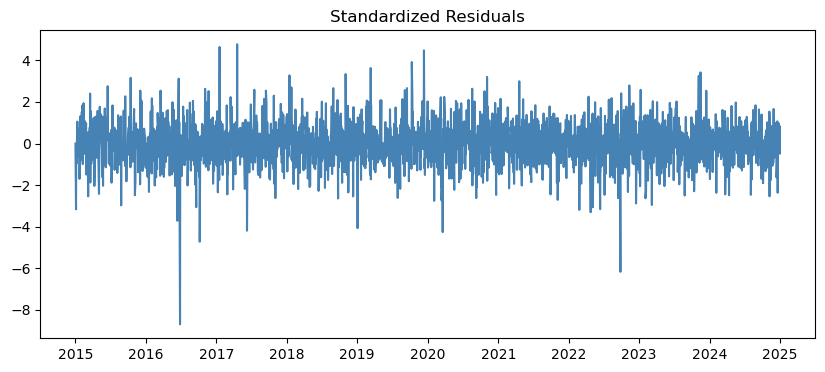

      lb_stat  lb_pvalue
10   4.898478   0.897856
20  15.337536   0.756779
      lb_stat  lb_pvalue
10   7.474276   0.680039
20  12.476554   0.898698


In [16]:
std_resid = model_fit.std_resid.dropna()

# Plot residuals
plt.figure(figsize=(10,4))
plt.plot(std_resid, color='steelblue')
plt.title("Standardized Residuals")
plt.show()

# Check autocorrelation
lb = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
print(lb)

# check squared residuals
lb_sq = acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True)
print(lb_sq)

#print(std_resid.describe())

In [17]:
# Realized volatility (21-day rolling std)
realized_vol = pct_returns.rolling(window=21).std()
garch_vol = model_fit.conditional_volatility  # match scale if returns were *100

# Align and drop NaNs
df_eval = pd.concat([realized_vol, garch_vol], axis=1).dropna()
df_eval.columns = ['realized', 'garch']

# Metrics
mae = mean_absolute_error(df_eval['realized'], df_eval['garch'])
rmse = root_mean_squared_error(df_eval['realized'], df_eval['garch'])
corr = df_eval['realized'].corr(df_eval['garch'])

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"Correlation: {corr:.3f}")

MAE: 0.080082
RMSE: 0.115271
Correlation: 0.881


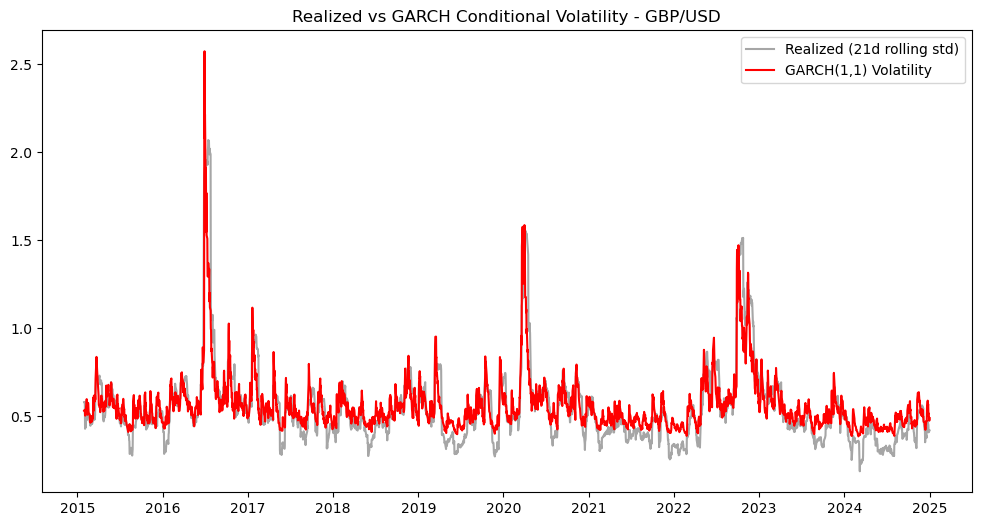

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df_eval.index, df_eval['realized'], label='Realized (21d rolling std)', color='gray', alpha=0.7)
plt.plot(df_eval.index, df_eval['garch'], label='GARCH(1,1) Volatility', color='red')
plt.legend()
plt.title("Realized vs GARCH Conditional Volatility - GBP/USD")
plt.show()

In [29]:
rolling_predictions = []
test_size = 365

# create 1-step-ahead volatility forecast
for i in range(test_size):
    train = pct_returns[:-(test_size-i)]
    model = arch_model(train, p=2, q=2, dist='t') # student-t residuals capture fat-tailed shocks better
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

forecasted_vol = np.array(rolling_predictions)
print(forecasted_vol)

[0.52445197 0.49610131 0.50698113 0.48538931 0.49741604 0.47079444
 0.47766369 0.45897715 0.46548855 0.44807991 0.45150267 0.44095489
 0.44307959 0.48394097 0.51075314 0.46719112 0.49084423 0.47372049
 0.50231093 0.48453814 0.51349314 0.47952456 0.51614172 0.48866283
 0.49435622 0.47171575 0.47620308 0.4567159  0.48266581 0.48167582
 0.46479102 0.46419551 0.46364257 0.47367355 0.4636009  0.47273011
 0.46713127 0.47847801 0.46900596 0.48705276 0.48652119 0.51984549
 0.47987241 0.51985796 0.48059885 0.50218571 0.47330109 0.49033314
 0.51235339 0.55680654 0.50329486 0.54342845 0.49052245 0.51906986
 0.47379181 0.51855175 0.51934378 0.5395511  0.51464426 0.51787435
 0.50144838 0.50753231 0.48367293 0.48955973 0.55865527 0.62326823
 0.53826844 0.59201532 0.52297137 0.57501551 0.50717413 0.65584407
 0.68728038 0.62918103 0.637627   0.60127411 0.60893226 0.57649688
 0.58598748 0.56265523 0.57218792 0.55170243 0.56487177 0.53383087
 0.56491435 0.55097389 0.56143783 0.53191565 0.53801892 0.5137

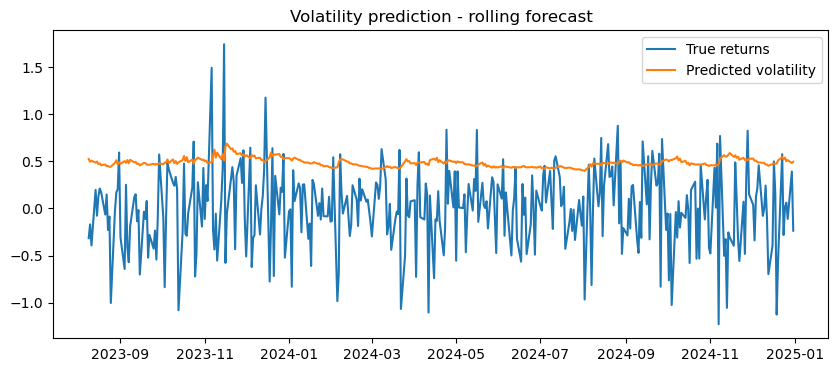

In [31]:
rolling_predictions = pd.Series(rolling_predictions, index=pct_returns.index[-365:])

plt.figure(figsize=(10, 4))
true, = plt.plot(pct_returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility prediction - rolling forecast')
plt.legend(['True returns', 'Predicted volatility'])

In [32]:
# Compute realized variance (squared returns)
realized_var = (pct_returns[-365:]/100) ** 2

# Make sure both are aligned
df_eval = pd.concat([rolling_predictions, realized_var], axis=1)
df_eval.columns = ['forecast_vol', 'realized_var']
df_eval['forecast_vol'] = (df_eval['forecast_vol']/10) ** 2

print(df_eval.head())

mae = mean_absolute_error(df_eval['realized_var'], df_eval['forecast_vol'])
rmse = root_mean_squared_error(df_eval['realized_var'], df_eval['forecast_vol'])
corr = df_eval['realized_var'].corr(df_eval['forecast_vol'])

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"Correlation: {corr:.3f}")

            forecast_vol  realized_var
Date                                  
2023-08-09      0.002750  9.984696e-06
2023-08-10      0.002461  2.862281e-06
2023-08-11      0.002570  1.542759e-05
2023-08-14      0.002356  3.872364e-06
2023-08-15      0.002474  5.988427e-07
MAE: 0.002358
RMSE: 0.002402
Correlation: 0.031


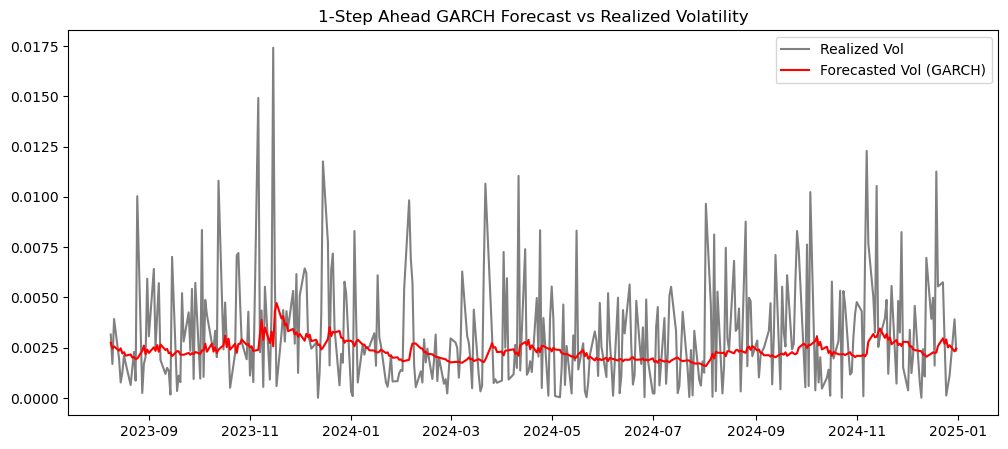

In [33]:
plt.figure(figsize=(12,5))
plt.plot(np.sqrt(df_eval['realized_var']), label='Realized Vol', color='gray')
plt.plot(df_eval['forecast_vol'], label='Forecasted Vol (GARCH)', color='red')
plt.legend()
plt.title("1-Step Ahead GARCH Forecast vs Realized Volatility")
plt.show()

In [34]:
naive_forecast = df_eval['realized_var'].shift(1)
corr_naive = df_eval['realized_var'][1:].corr(naive_forecast[1:])
print(corr_naive)

0.029040130685898956
